<a href="https://colab.research.google.com/github/joaquinhojman/ArbolesDeDecision/blob/main/XGBoost_with_RandomSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve


from sklearn.model_selection import train_test_split

In [3]:
url_train = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_train.csv'
url_test = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_test.csv'
url_test_kaggle = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_test_kaggle.csv'

data_train = pd.read_csv(url_train)
data_test = pd.read_csv(url_test)
data_test_kaggle = pd.read_csv(url_test_kaggle)

In [4]:
# Separamos los set de datos (data_train y data_test) de sus columnas 'Target'
# 'x' son los datos, 'y' es el target:
#   --> x_train son los datos con los que entrenar
#   --> y_train son las soluciones con las que comparar lo entrenado con x_train
#   --> x_test son los datos con los que probar
#   --> y_test son las soluciones con las que comparar lo probado con x_test
x_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
x_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]
#Esto lo hizo chechu y esta bien, no cambiar.

In [ ]:
 xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5 , 
                           alpha = 10, n_estimators = 30, eta=0.2,nthread=2,objective='reg:logistic',
                           booster='gbtree',max_features=12,error='log_loss')
 xg_reg.fit(x_train, y_train)
 preds = xg_reg.predict(x_test) 


In [ ]:
error = log_loss(y_test, preds)
error

0.46711989397556913

In [ ]:
preds_train = xg_reg.predict(x_train)
error_train = log_loss(y_train, preds_train)
error_train

0.27719485771279234

#K-fold cross validation

In [ ]:
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

In [ ]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)

In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.477699,0.000227,0.478314,0.000296
1,0.458716,0.001737,0.459921,0.002044
2,0.444701,0.004672,0.446109,0.005041
3,0.429546,0.003592,0.431349,0.004788
4,0.414783,0.001592,0.417121,0.003618


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.283661
Name: test-rmse-mean, dtype: float64


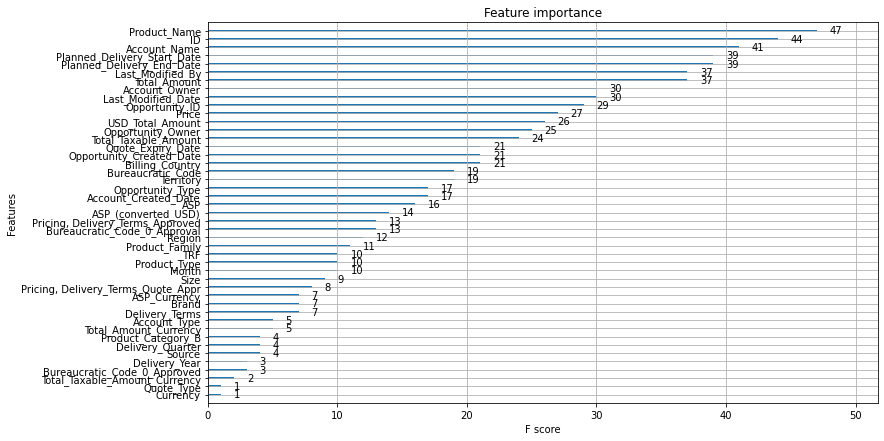

In [ ]:
## Importancia de los features (cuantas veces aparecen en los árboles)
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

##PREDICCIONES

In [ ]:
# Sacamos el y_test_de_practica_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

stage_test_de_practica = y_test.to_frame()

oportunidades_test_de_practica['Target'] = stage_test_de_practica
y_test_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
y_test_agrupado_por_opp = y_test_agrupado_por_opp.reset_index()

In [ ]:
# Sacamos el preds_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

oportunidades_test_de_practica['Target'] = preds

preds_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_agrupado_por_opp = preds_agrupado_por_opp.reset_index()

In [ ]:
# Calculamos el error con groupby hecho
error = log_loss(y_test_agrupado_por_opp['Target'], np.nan_to_num(preds_agrupado_por_opp['Target'].to_numpy()))
error

0.47448770772641846

In [ ]:
# Sacamos el preds_test_agrupado_por_opp

preds_test_kaggle = xg_reg.predict(data_test_kaggle)

oportunidades_test = data_test_kaggle['Opportunity_ID']
oportunidades_test = oportunidades_test.to_frame()

oportunidades_test['Target'] = preds_test_kaggle

preds_test_kaggle_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_test_kaggle_agrupado_por_opp = preds_test_kaggle_agrupado_por_opp.reset_index()

preds_test_kaggle_agrupado_por_opp['Opportunity_ID'] = preds_test_kaggle_agrupado_por_opp['Opportunity_ID'].astype(int)

preds_test_kaggle_agrupado_por_opp

,Opportunity_ID,Target
0,10689,0.634689
1,10690,0.628170
2,10691,0.303766
3,10692,0.401722
4,10693,0.623845
...,...,...
1562,12364,0.464867
1563,12365,0.242578
1564,12366,0.177082
1565,12367,0.205320


In [ ]:
from google.colab import files

preds_test_kaggle_agrupado_por_opp.to_csv('preds_testxgb.csv', index=False, header=True)
files.download('preds_testxgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Optimizacion de hiperparametros

Grid Search for Regression


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [ ]:
# Espacio de hiperparámetros

search_space = {
                'alpha' : [8,10,12,14,15,16,16,18,19,20],
                'max_depth' : [4,5,6,7,8,9,10],
                'max_features' : [10, 12, 14,16,18,19,21,20],
                'min_samples_split' : [2, 50,75,100,125,150,175, 200],
                'learning_rate' : [0.001,0.01,0.05,0.1,0.5,1]}
opt = RandomizedSearchCV(estimator=xg_reg, error_score='log_loss', param_distributions=search_space, n_iter = 100)

In [ ]:
opt

RandomizedSearchCV(cv=None, error_score='log_loss',
                   estimator=XGBRegressor(alpha=10, base_score=0.5,
                                          booster='gbtree', colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.3,
                                          error='log_loss', eta=0.2, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, max_features=12,
                                          min_child_weight=1, missing=None,
                                          n_estimators=30, n_jobs=1, nthread=2,
                                          objective='reg:logistic',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
       

In [ ]:
opt.fit(x_train, y_train)
print(opt.best_params_)


{'min_samples_split': 175, 'max_features': 16, 'max_depth': 8, 'learning_rate': 0.5, 'alpha': 18}


In [ ]:
 xg_reg_optimizado = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 9, 
                           alpha = 10, n_estimators = 30, eta=0.2,nthread=2,objective='reg:logistic',
                           booster='gbtree',max_features=14,error='log_loss',min_samples_split=100)
 xg_reg_optimizado.fit(x_train, y_train)
 preds_optimizadas = xg_reg_optimizado.predict(x_test) 


In [ ]:
error = log_loss(y_test, preds_optimizadas)
error

0.4693067664486759

In [ ]:
# Sacamos el y_test_de_practica_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

stage_test_de_practica = y_test.to_frame()

oportunidades_test_de_practica['Target'] = stage_test_de_practica
y_test_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
y_test_agrupado_por_opp = y_test_agrupado_por_opp.reset_index()

In [ ]:
# Sacamos el preds_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

oportunidades_test_de_practica['Target'] = preds_optimizadas

preds_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_agrupado_por_opp = preds_agrupado_por_opp.reset_index()

In [ ]:
# Calculamos el error con groupby hecho
error = log_loss(y_test_agrupado_por_opp['Target'], np.nan_to_num(preds_agrupado_por_opp['Target'].to_numpy()))
error

0.47061725805288884

In [ ]:
# Sacamos el preds_test_agrupado_por_opp
preds_test_kaggle = xg_reg_optimizado.predict(data_test_kaggle)

oportunidades_test = data_test_kaggle['Opportunity_ID']
oportunidades_test = oportunidades_test.to_frame()

oportunidades_test['Target'] = preds_test_kaggle

preds_test_kaggle_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_test_kaggle_agrupado_por_opp = preds_test_kaggle_agrupado_por_opp.reset_index()

preds_test_kaggle_agrupado_por_opp

,Opportunity_ID,Target
0,10689,0.381261
1,10690,0.314539
2,10691,0.161561
3,10692,0.349053
4,10693,0.417359
...,...,...
1562,12364,0.477994
1563,12365,0.134094
1564,12366,0.105533
1565,12367,0.090524


In [ ]:
from google.colab import files

preds_test_kaggle_agrupado_por_opp.to_csv('preds_testxgb.csv', index=False, header=True)
files.download('preds_testxgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 HyperOpt para optimizacion
 

In [ ]:
# fmin: class which will host optimization process
# tpe: the optimizer to be used (Tree of Parzen Estimator)
# hp: for defining the search space
from hyperopt.pyll.base import scope 
import warnings
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(space):
  warnings.filterwarnings(action='ignore', category=DeprecationWarning)
  model = xgb.XGBRFRegressor(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            ).fit(x_train, y_train)
  logloss = log_loss(y_test, model.predict(x_test))
  print(logloss)
  return {
    'loss': logloss,
    'status': STATUS_OK
  }

# Search space definition
# space = hp.uniform('x', -2, 2)
space = {
    'max_depth' : hp.choice('max_depth', range(4, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}


# Init the optimizer
# fn: function to be optimized
# space: search space
# algo: optimizer algorithm
# max_evals: number of iterations
best = fmin(
    fn=objective,  
    space=space,
    algo=tpe.suggest,
    max_evals=1000
)

print(f"Optimal value of x: {best}")

[15:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5969413919357804
[15:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6591534338595954
[15:33:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6399748736210586
[15:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.625370594772663
[15:33:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6586238660002122
[15:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5725968513370902
[15:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

In [5]:
from hyperopt.pyll.base import scope 
import warnings
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Search space definition
# space = hp.uniform('x', -2, 2)
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 0.01,8),
        'reg_alpha' : hp.quniform('reg_alpha', 40,50,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.1,1,0.01),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 30,31,1),
        'learning_rate' : hp.quniform('learning_rate', 0.1, 0.5, 0.01),
        'subsample' : hp.quniform('subsample', 0.5, 1, 0.01),
        'max_features' : hp.quniform('max_features',8,16,1),
        'min_samples_split' :hp.quniform('min_samples_split',2,100,25),
        'eta' : hp.quniform('eta', 0.1,1,0.01),
        'nthread' : hp.quniform('nthread', 1,10,1),

    }
                    
# Regression: 
def hyperparameter_tuning(space):
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    model=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'], reg_lambda=space['reg_lambda'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],learning_rate=space['learning_rate'],
                         colsample_bytree=space['colsample_bytree'],max_features=int(space['max_features']),subsample=space['subsample'],
        min_samples_split = int(space['min_samples_split']),eta =space['eta'],nthread =int(space['nthread']),
        objective = 'reg:logistic',booster='gbtree',error='log_loss')
                            
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(x_test)

    logloss = log_loss(y_test, pred)
    print(logloss)
    #change the metric if you like
    return {'loss':logloss, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=700,
            trials=trials)

print (best)

0.5170267626087365
0.5489371216565353
0.5256940147427587
0.540108685109868
0.5162579220504037
0.5216031725545425
0.5369627091618968
0.5736368858382821
0.5581828765725511
0.5451120925486053
0.5022244880801919
0.5270678898139844
0.5174778225319433
0.5687644639581247
0.5125843358505683
0.5226252412146686
0.580682129920623
0.5256582224811055
0.4869078656354155
0.5252934593107395
0.49304209502668617
0.536816164716646
0.47688920894508674
0.5069532842094673
0.49828922462496905
0.5192253072478666
0.5212994198705792
0.5045517697498034
0.5344265941199623
0.5221214334002396
0.5376270644321526
0.5411809110179182
0.5032480321317259
0.5146932346628325
0.5372932707425483
0.5348096550075594
0.5263201786197453
0.5461825337360214
0.48685784127658077
0.5123665442523729
0.5091579867786876
0.4985093432051268
0.513457806042052
0.47395198746121725
0.537308453441619
0.547082814889204
0.5051838060079474
0.4503538101164943
0.5185079871940985
0.5053454805874085
0.6126927813154448
0.524025796949279
0.513285660527

In [51]:
#best loss: 0.4149496828361931   En kaggle: 0.548...
#{'colsample_bytree': 0.16, 'eta': 0.44, 'gamma': 1.8184733320621085, 'learning_rate': 0.5, 'max_depth': 3.0,
# 'max_features': 9, 'min_child_weight': 4.0, 'min_samples_split': 5, 'n_estimators': 21, 'nthread': 2, 
# 'reg_alpha': 41.0, 'reg_lambda': 0.41835045298592066, 'subsample': 0.98}



In [6]:
#best loss: 0.41586248273147924   
#{'colsample_bytree': 0.15, 'eta': 0.27, 'gamma': 3.7825999855322325, 'learning_rate': 0.5, 'max_depth': 3.0,
# 'max_features': 12.0, 'min_child_weight': 1.0, 'min_samples_split': 0.0, 'n_estimators': 31.0, 'nthread': 1.0,
 # 'reg_alpha': 40.0, 'reg_lambda': 0.5801275219961897, 'subsample': 0.99}


best

{'colsample_bytree': 0.15,
 'eta': 0.27,
 'gamma': 3.7825999855322325,
 'learning_rate': 0.5,
 'max_depth': 3.0,
 'max_features': 12.0,
 'min_child_weight': 1.0,
 'min_samples_split': 0.0,
 'n_estimators': 31.0,
 'nthread': 1.0,
 'reg_alpha': 40.0,
 'reg_lambda': 0.5801275219961897,
 'subsample': 0.99}

In [12]:
 xg_hyper = xgb.XGBRegressor(n_estimators =30, max_depth = 3, gamma =3.7825999855322325, reg_lambda=0.5801275219961897,
                         reg_alpha = 40,min_child_weight=1,learning_rate=0.5,
                         colsample_bytree= 0.15,max_features=12,subsample=0.99,
        min_samples_split = 0,eta = 0.27,nthread =1,
        objective = 'reg:logistic',booster='gbtree',error='log_loss')
     
xg_hyper.fit(x_train, y_train)

pred_hyper = xg_hyper.predict(x_test)

logloss_hyper = log_loss(y_test, pred_hyper)
logloss_hyper

0.42355670071746815

In [54]:
logloss_hyper

In [17]:
#Error de train
preds_train_hyper = xg_hyper.predict(x_train)
error_train_hyper = log_loss(y_train, preds_train_hyper)
error_train_hyper

0.26710468064342796

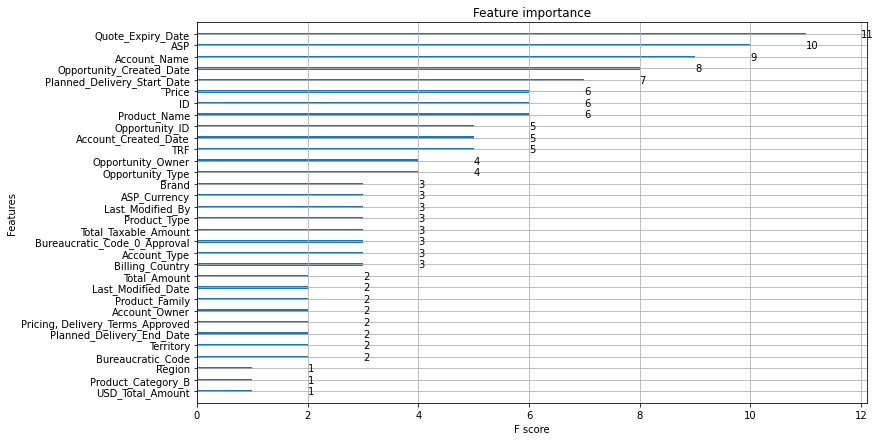

In [61]:
## Importancia de los features (cuantas veces aparecen en los árboles)
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_hyper)

In [13]:
# Sacamos el y_test_de_practica_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

stage_test_de_practica = y_test.to_frame()

oportunidades_test_de_practica['Target'] = stage_test_de_practica
y_test_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
y_test_agrupado_por_opp = y_test_agrupado_por_opp.reset_index()

In [14]:
# Sacamos el preds_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

oportunidades_test_de_practica['Target'] = pred_hyper

preds_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_agrupado_por_opp = preds_agrupado_por_opp.reset_index()

In [15]:
# Calculamos el error con groupby hecho
error = log_loss(y_test_agrupado_por_opp['Target'], np.nan_to_num(preds_agrupado_por_opp['Target'].to_numpy()))
error

0.4364663851913754

In [16]:
# Sacamos el preds_test_agrupado_por_opp
preds_test_kaggle_hyper = xg_hyper.predict(data_test_kaggle)

oportunidades_test = data_test_kaggle['Opportunity_ID']
oportunidades_test = oportunidades_test.to_frame()

oportunidades_test['Target'] = preds_test_kaggle_hyper

preds_test_kaggle_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_test_kaggle_agrupado_por_opp = preds_test_kaggle_agrupado_por_opp.reset_index()
preds_test_kaggle_agrupado_por_opp['Opportunity_ID'] = preds_test_kaggle_agrupado_por_opp['Opportunity_ID'].astype(int)

preds_test_kaggle_agrupado_por_opp

,Opportunity_ID,Target
0,10689,0.741462
1,10690,0.690054
2,10691,0.361460
3,10692,0.350053
4,10693,0.742758
...,...,...
1562,12364,0.753860
1563,12365,0.504180
1564,12366,0.368788
1565,12367,0.407723


In [50]:
from google.colab import files

preds_test_kaggle_agrupado_por_opp.to_csv('preds_testxgb_hyper.csv', index=False, header=True)
files.download('preds_testxgb_hyper.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>